In [1]:
import os
import numpy as np
from dask.distributed import Client
from dask import delayed
import dask.array as da
from skimage.transform import resize
from skimage.color import rgb2gray

from skimage.io import imread, imread_collection, imsave, ImageCollection

import warnings
warnings.filterwarnings('ignore') 

import matplotlib.pyplot as plt
%matplotlib inline

# Supervised Learning with Design Safe Data

In this demo, we use the same pipeline created in the city vs forest classifier notebook, but with all the DesignSafe Data. Let's see how our new models perform.

### Copy data for this notebook to your compute node

In [2]:
! cp -r /work/00791/xwj/DMS/sc21-pdl/data/data.tar.gz /tmp/
! tar zxf /tmp/data.tar.gz -C /tmp

/bin/bash: warning: setlocale: LC_ALL: cannot change locale (en_US.UTF-8)
/bin/bash: warning: setlocale: LC_ALL: cannot change locale (en_US.UTF-8)


### Import data using EDA pipline from DEMO 1

In [3]:
client = Client()

In [4]:
from src.get_data_dask import get_all_data

classes = [0,2,4]
path_train = '/tmp/Dataset_2/Train/C{}/'
path_test = '/tmp/Dataset_2//Validation/C{}/'

path_list_train = [path_train.format(class_) for class_ in classes]
path_list_test = [path_test.format(class_) for class_ in classes]
        
train, test, y_train, y_test = get_all_data(path_list_train, path_list_test, classes, size=(112,112),gray=True)

/tmp/Dataset_2/Train/C0/
/tmp/Dataset_2/Train/C2/
/tmp/Dataset_2/Train/C4/
/tmp/Dataset_2//Validation/C0/
/tmp/Dataset_2//Validation/C2/
/tmp/Dataset_2//Validation/C4/


In [5]:
X_train = train.compute()

In [6]:
X_test = test.compute()

In [7]:
client.close()

In [8]:
shape_train_all = X_train.shape
shape_test_all = X_test.shape 
shape_image = X_train[0].shape

In [9]:
image_shape =  (112,112,3)

### Reshape data to classic feature and target

In [10]:
X_train = X_train.reshape((len(X_train),-1))
X_test = X_test.reshape((len(X_test),-1))
X_train.shape,X_test.shape

((1322, 12544), (363, 12544))

### Functions for Model Evaluation 

In [11]:
from sklearn.metrics import roc_curve, classification_report, confusion_matrix, ConfusionMatrixDisplay
import pandas as pd

def plot_roc(model):
    """
    Plots multiclass (>2 labels) ROC curve
    """
    classes = ['low','medium','high']
    y_test_dummied = pd.get_dummies(y_test).values
    predicted_probs = model.predict_proba(X_test)

    fig,ax=plt.subplots()
    for i,class_ in enumerate(classes):
        fpr,tpr,thresholds = roc_curve(y_test_dummied[:,i],predicted_probs[:,i])
        ax.plot(fpr,tpr,label=class_)
        ax.plot([0,1],[0,1],color='k',ls='--')
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
    ax.legend()

def evaluate(model, X_train, X_test, y_train, y_test, roc=True):
    """
    Computes and prints accuracy score on train and test data, and various metrics using testing data
    Plots the confusion matrix and ROC curve if requested
    """
    accuracy_test = accuracy_score(y_test, model.predict(X_test))
    print('Accuracy on the Test Data is {:.2f}'.format(accuracy_test))
    print('Accuracy on the Training Data is {:.2f}'.format(accuracy_score(y_train, model.predict(X_train))))
    if roc:
        plot_roc(model)
    cm_display = ConfusionMatrixDisplay.from_estimator(model, X_test, y_test,
                                                   cmap=plt.cm.Blues,normalize=None)
    return accuracy_test 

### Decision Tree

In [12]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score 

clf_dt = DecisionTreeClassifier()
clf_dt.fit(X_train, y_train)

DecisionTreeClassifier()

Accuracy on the Test Data is 0.41
Accuracy on the Training Data is 1.00


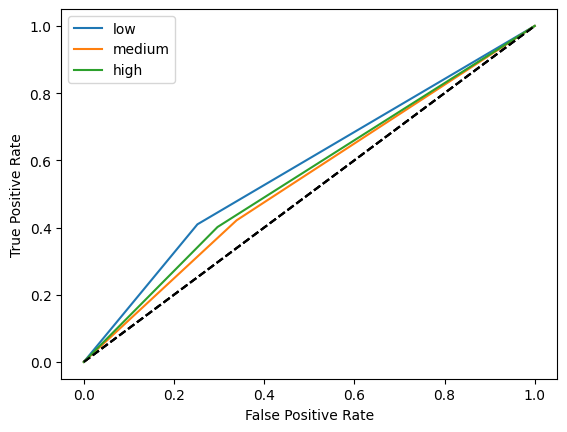

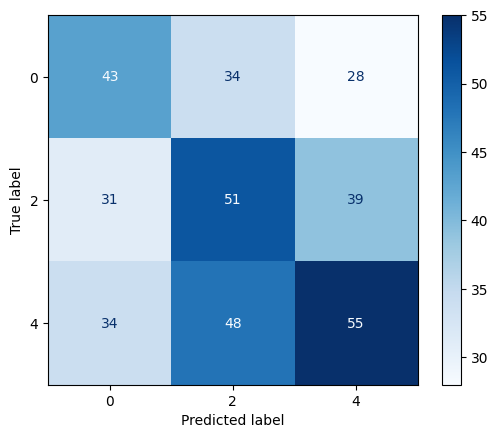

In [13]:
accuracy_dt = evaluate(clf_dt, X_train, X_test, y_train, y_test)

### Logistic Regression

In [14]:
from sklearn.linear_model import LogisticRegression
clf_lr = LogisticRegression(random_state=0).fit(X_train, y_train)

Accuracy on the Test Data is 0.38
Accuracy on the Training Data is 0.94


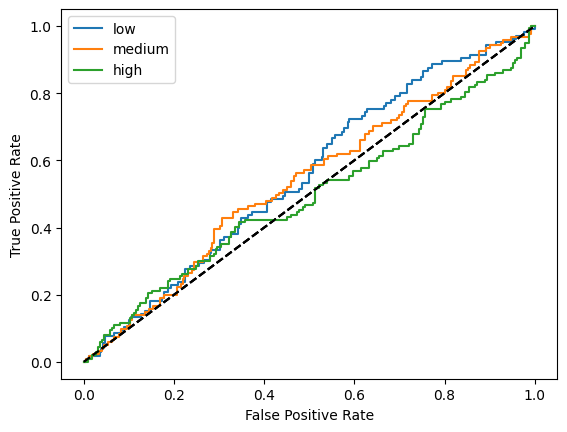

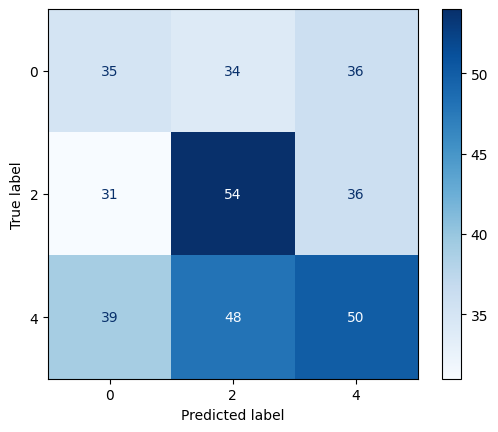

In [15]:
accuracy_lr = evaluate(clf_lr, X_train, X_test, y_train, y_test)

### Naive Bayes Classifier

In [16]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
y_pred = gnb.fit(X_train, y_train)

Accuracy on the Test Data is 0.46
Accuracy on the Training Data is 0.47


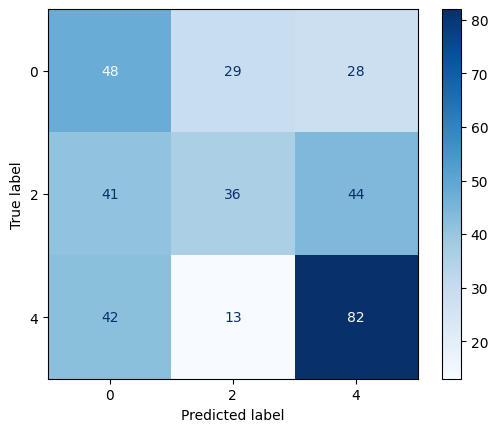

In [17]:
accuracy_nb = evaluate(gnb, X_train, X_test, y_train, y_test, roc=False )

### Support Vector Machine Classifier

In [18]:
#RBF Kernel normlize

In [19]:
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

clf_svm = SVC(C=10).fit(X_train_scaled, y_train)

Accuracy on the Test Data is 0.48
Accuracy on the Training Data is 1.00


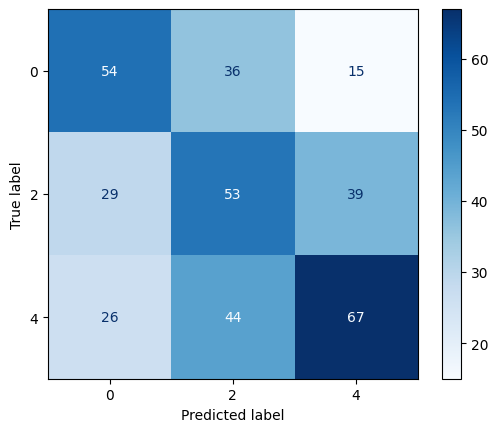

In [20]:
accuracy_svm = evaluate(clf_svm, X_train_scaled, X_test_scaled, y_train, y_test , roc=False)

### Random Forest

In [21]:
from sklearn.ensemble import RandomForestClassifier
clf_rf = RandomForestClassifier()
clf_rf.fit(X_train, y_train)

RandomForestClassifier()

Accuracy on the Test Data is 0.47
Accuracy on the Training Data is 1.00


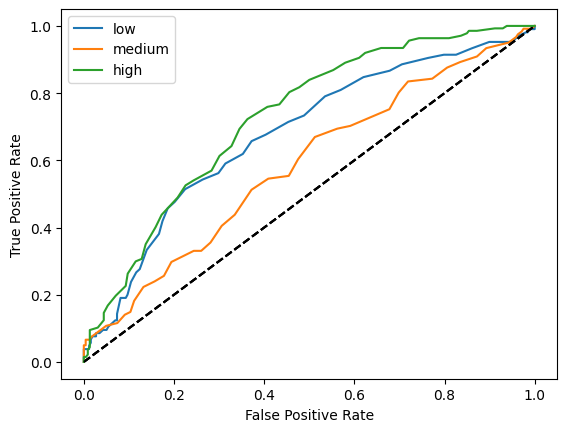

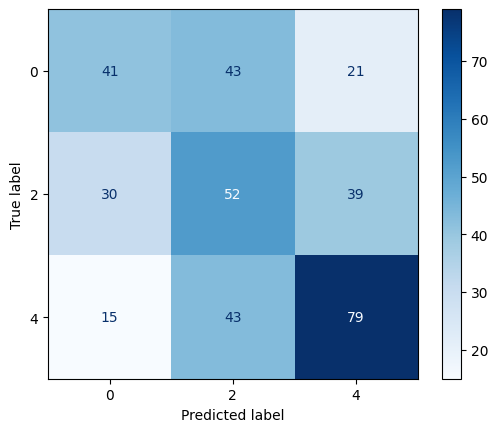

In [22]:
accuracy_rf = evaluate(clf_rf, X_train, X_test, y_train, y_test )

In [23]:
summary ='''
       Accuracy of all models: \n
       Decision Tree: {:.2f}\n
       Logistic Regression: {:.2f}\n
       Naive Bayes: {:.2f}\n
       Support Vector Machine: {:.2f} \n
       Random Forest {:.2f}
       '''.format(accuracy_dt, accuracy_lr, accuracy_nb, accuracy_svm, accuracy_rf)

print(summary)


       Accuracy of all models: 

       Decision Tree: 0.41

       Logistic Regression: 0.38

       Naive Bayes: 0.46

       Support Vector Machine: 0.48 

       Random Forest 0.47
       


Finally, lets take a look at what we got right and wrong in our highest performing model with a specific focus on the low versus high damage classes. 

In [24]:
yhat = clf_rf.predict(X_test)
y_test = np.array(y_test)

misclassifications0 = X_test[ (y_test == 0) & (yhat == 4)]
misclassifications4 = X_test[ (y_test == 4) & (yhat == 0)]
misclassifications0.shape, misclassifications4.shape

((21, 12544), (15, 12544))

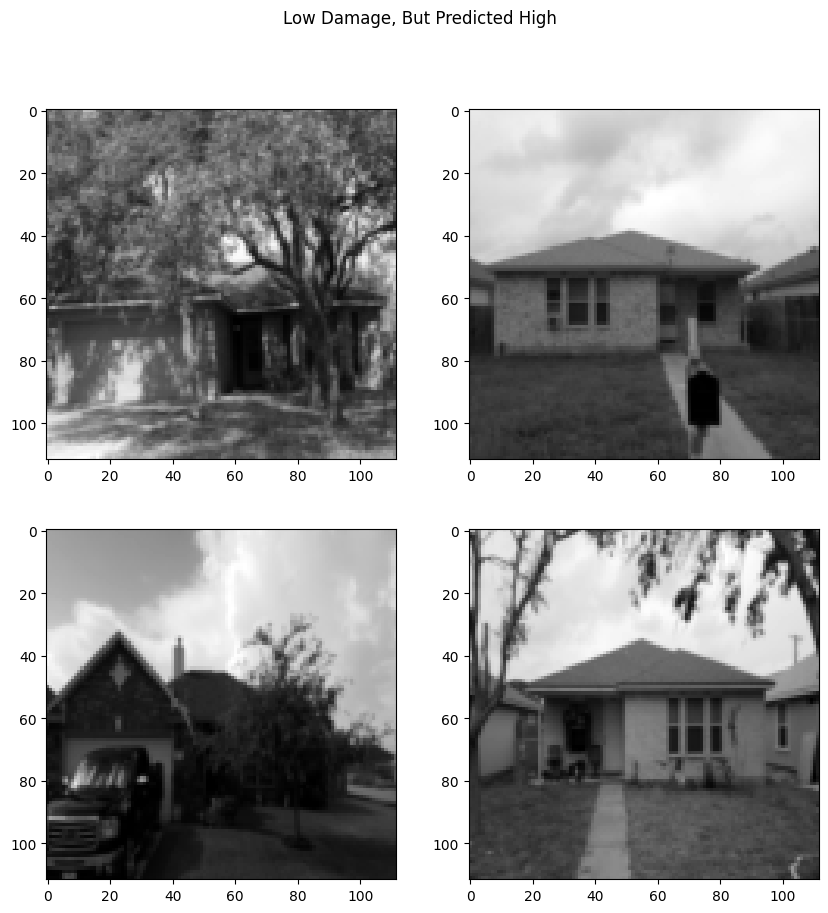

In [25]:
fig,ax = plt.subplots(2,2,figsize=(10,10))
for i,ax in enumerate(ax.flatten()):
    ax.imshow(misclassifications0[i].reshape(shape_image),cmap='gray')
fig.suptitle('Low Damage, But Predicted High');

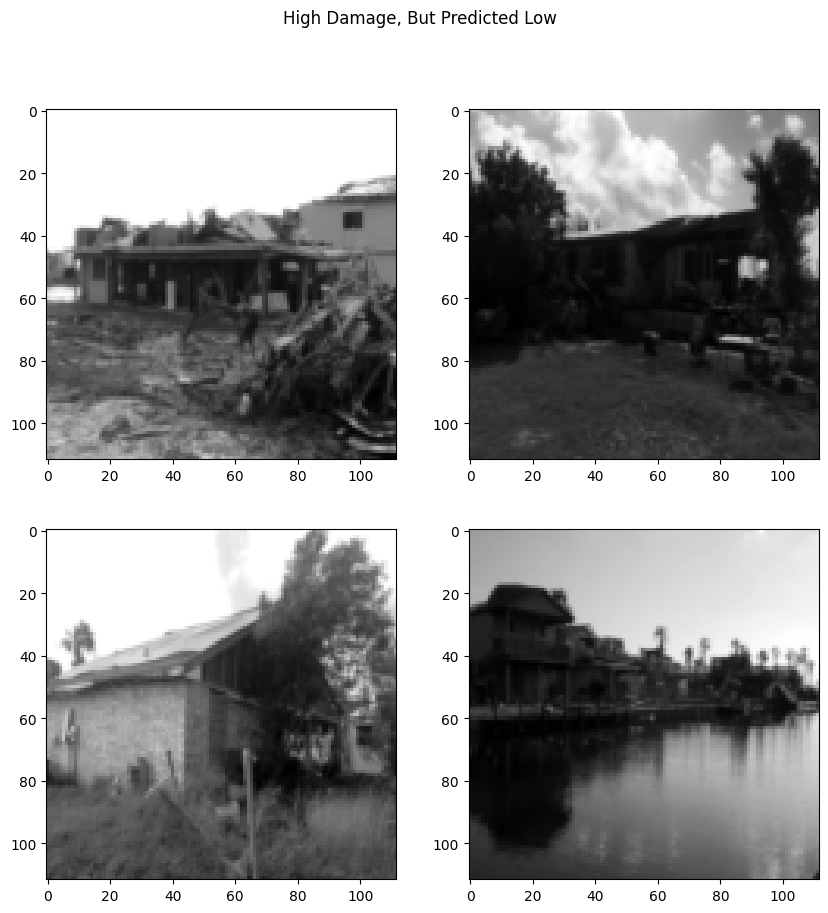

In [26]:
fig,ax = plt.subplots(2,2,figsize=(10,10))
for i,ax in enumerate(ax.flatten()):
    ax.imshow(misclassifications4[i].reshape(shape_image),cmap='gray')
fig.suptitle('High Damage, But Predicted Low');

In [27]:
correct0 = X_test[ (y_test == 0) & (yhat == 0)]
correct4 = X_test[ (y_test == 4) & (yhat == 4)]
correct0.shape, correct4.shape

((41, 12544), (79, 12544))

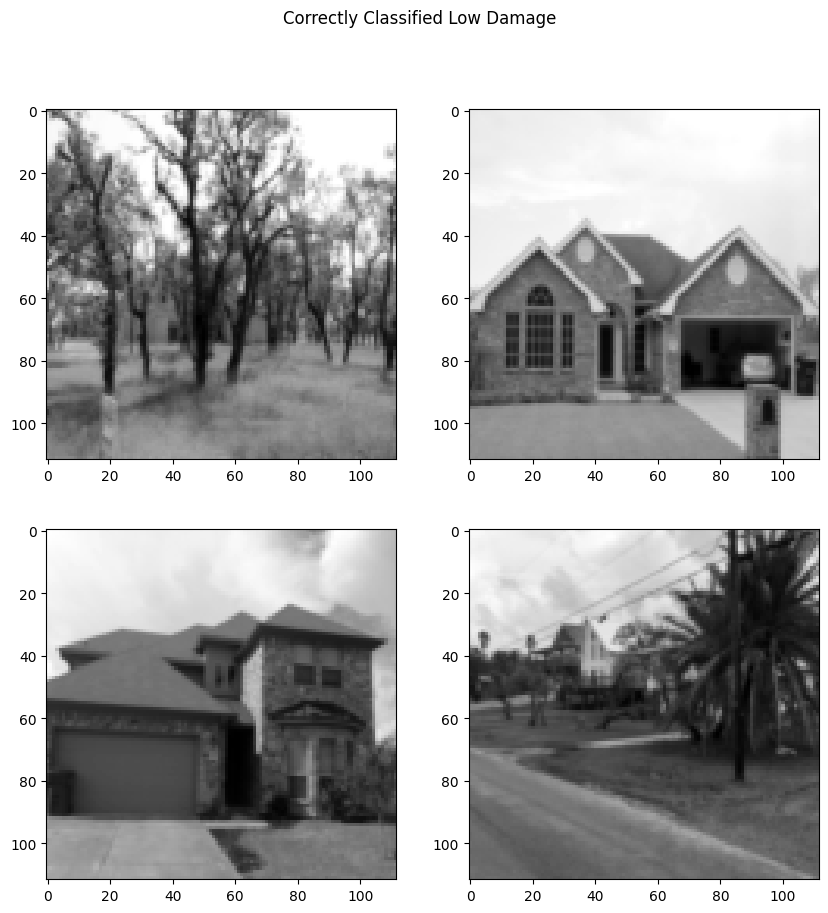

In [28]:
fig,ax = plt.subplots(2,2,figsize=(10,10))
for i,ax in enumerate(ax.flatten()):
    ax.imshow(correct0[i].reshape(shape_image),cmap='gray')
fig.suptitle('Correctly Classified Low Damage');

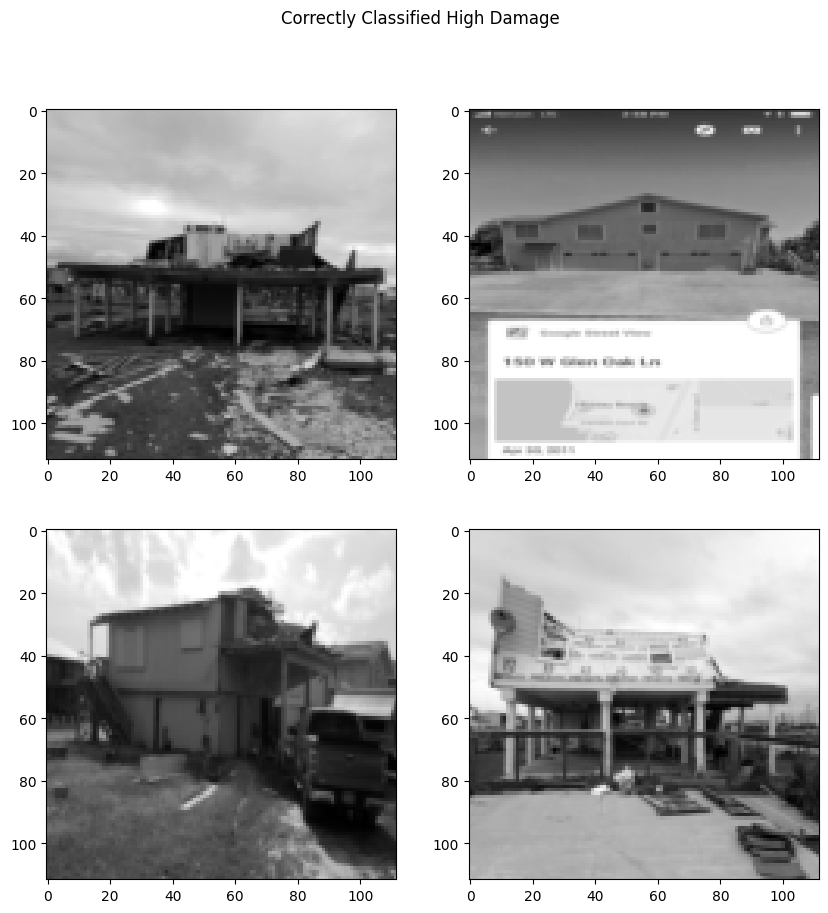

In [29]:
fig,ax = plt.subplots(2,2,figsize=(10,10))
for i,ax in enumerate(ax.flatten()):
    ax.imshow(correct4[i].reshape(shape_image),cmap='gray')
fig.suptitle('Correctly Classified High Damage');

Finally, we can explore how our best performing model, a random forest, is making predictions by leveraging feature importances.  Below we visualize the feature importances for each pixel in our model where white pixels are very important and black pixels are not. 

Text(0, 0.5, 'Feature Importance')

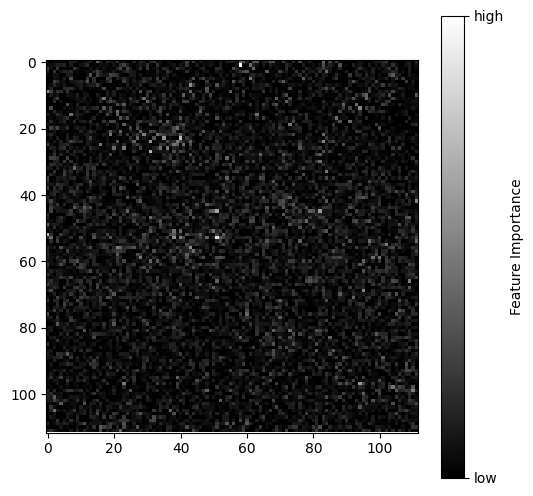

In [30]:
min_ = clf_rf.feature_importances_.min()
max_ = clf_rf.feature_importances_.max()

fig,ax = plt.subplots(figsize=(6,6))
cax = ax.imshow(clf_rf.feature_importances_.reshape((shape_image)),cmap='gray')
# Add colorbar, make sure to specify tick locations to match desired ticklabels
cbar = fig.colorbar(cax, ticks=[min_,max_])
cbar.ax.set_yticklabels(['low','high'])  # vertically oriented colorbar
cbar.ax.set_ylabel('Feature Importance')

**Questions** Is it obvious how our random forest model is making decisions here? 